In [1]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import vmap
from jax import jit, lax
import matplotlib.pyplot as plt
import cmocean as cmo
import importlib

In [2]:
from jax.config import config
config.update("jax_enable_x64", True)

In [3]:
## import modules
import bbmm.utils.preconditioner as precond
import bbmm.utils.conjugate_gradient as cg
import bbmm.functions.pivoted_cholesky as pc
import bbmm.functions.pivoted_cholesky_ref as pc_ref # to use this script we need "torch", please comment out if not needed.
import bbmm.utils.calc_logdet as calc_logdet
import bbmm.utils.calc_trace as calc_trace
import bbmm.operators.dense_linear_operator as dense_linear_operator
import bbmm.operators.root_linear_operator as root_linear_operator
import bbmm.operators.diag_linear_operator as diag_linear_operator
import bbmm.operators._linear_operator as _linear_operator
import bbmm.operators.psd_sum_linear_operator as psd_sum_linear_operator
import bbmm.operators.root_linear_operator as root_linear_operator
from bbmm.functions.pivoted_cholesky_numpy import pivoted_cholesky_numpy
def reload():
    importlib.reload(precond)
    importlib.reload(cg)
    importlib.reload(pc)
    importlib.reload(pc_ref)
    importlib.reload(calc_logdet)
    importlib.reload(calc_trace)
    importlib.reload(dense_linear_operator)
    importlib.reload(root_linear_operator)
    importlib.reload(diag_linear_operator)
    importlib.reload(_linear_operator)
    importlib.reload(psd_sum_linear_operator)
    importlib.reload(root_linear_operator)
reload()

/home/ogawa_kenta/.conda/envs/mytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import gpytorch
import torch
import linear_operator
from linear_operator.operators import (
    AddedDiagLinearOperator,
    DiagLinearOperator,
    LinearOperator,
    DenseLinearOperator,
)

In [5]:
def generate_K(N, seed=0, noise=1e-06):
    """
    generate positive definite symmetric matrix
    """
    K = jax.random.normal(jax.random.PRNGKey(seed), (N, N))
    # K = K @ K.T + 30* jnp.eye(N) + noise*jnp.eye(N)
    # K = jnp.dot(K, K.T) + noise*jnp.eye(N)
    # K = jnp.dot(K, K.T) / N
    K = jnp.dot(K, K.T)/N
    # K += (noise+30)*jnp.eye(N) ## ??
    K += (2)*jnp.eye(N)
    K += (noise)*jnp.eye(N)
    if not is_positive_definite(K):
        raise Exception("K is not positive definite !")
    return K

In [6]:
def is_positive_definite(matrix):
    # 行列の固有値を計算
    eigenvalues = np.linalg.eigvals(matrix)

    # 全ての固有値が正であるかをチェック
    if np.all(eigenvalues > 0):
        return True
    else:
        return False

In [7]:
def rel_error(true, pred):
    nonzero_index = jnp.where(true != 0.)
    true = true[nonzero_index]
    pred = pred[nonzero_index]
    return jnp.mean(jnp.abs((true-pred)/true))

### check rootlinearop

In [8]:
sample_array = generate_K(3)

In [176]:
dense = dense_linear_operator.DenseLinearOp(sample_array)

In [177]:
dense.shape

(3, 3)

In [178]:
sample_array

DeviceArray([[3.29861794, 0.37361211, 0.80453457],
             [0.37361211, 2.74167   , 0.4826135 ],
             [0.80453457, 0.4826135 , 3.4315507 ]], dtype=float64)

In [179]:
root = root_linear_operator.RootLinearOp(sample_array)

In [180]:
root.matmul(sample_array)

DeviceArray([[43.97697109, 14.31114291, 29.86301791],
             [14.31114291, 24.20084905, 17.19047655],
             [29.86301791, 17.19047655, 49.51303359]], dtype=float64)

In [181]:
dense.matmul(dense.matmul(sample_array))

DeviceArray([[43.97697109, 14.31114291, 29.86301791],
             [14.31114291, 24.20084905, 17.19047655],
             [29.86301791, 17.19047655, 49.51303359]], dtype=float64)

In [182]:
diag = diag_linear_operator.DiagLinearOp(jnp.full(3, 1e-06))

In [183]:
diag.root_decomposition().matmul(sample_array)

DeviceArray([[3.29861794e-06, 3.73612114e-07, 8.04534573e-07],
             [3.73612114e-07, 2.74167000e-06, 4.82613497e-07],
             [8.04534573e-07, 4.82613497e-07, 3.43155070e-06]],            dtype=float64)

In [184]:
N = 4
L = jax.random.normal(key=jax.random.PRNGKey(0), shape = (N, 3))
noise = jnp.full(N, 1e-06)

In [187]:
precond_lt_new = psd_sum_linear_operator.PsdSumLinearOp(
    root_linear_operator.RootLinearOp(L),
    diag_linear_operator.DiagLinearOp(noise)
)

In [196]:
jnp.std(precond_lt_new.zero_mean_mvn_samples(30), axis=0)

DeviceArray([0.69259817, 0.84746309, 0.57059682, 0.4227692 , 0.84754852,
             0.91480462, 1.0085064 , 1.19646975, 2.0086326 , 0.67162618,
             0.99974826, 0.63706252, 0.82829175, 1.72501585, 0.74728799,
             1.44481853, 0.35150478, 1.50867536, 0.86776375, 0.68935824,
             0.39364083, 0.74093674, 0.87175085, 0.96593639, 0.67365309,
             1.49036013, 1.3769856 , 1.19452751, 0.91376743, 0.44264981],            dtype=float64)

In [197]:
precondition, precond_lt, precond_logdet_cache = precond.setup_preconditioner(L@L.T, rank=3, noise=1e-06, min_preconditioning_size=1)
zs = jax.random.multivariate_normal(
            jax.random.PRNGKey(0),
            jnp.zeros(len(L)),
            precond_lt,
            shape=(30,),
).T
jnp.std(zs, axis=0)

DeviceArray([1.70659786, 0.28576204, 1.38839897, 0.33440476, 1.30633693,
             1.16957061, 1.57803072, 0.65327961, 0.98631588, 0.54449982,
             1.74427669, 0.7544217 , 0.43267165, 0.76666073, 1.05847336,
             0.16916271, 0.32680483, 1.12172756, 0.94419746, 0.78947284,
             1.33208958, 0.58295598, 1.15524194, 0.32035689, 0.60667962,
             2.37129871, 1.13065544, 1.24455237, 1.01626742, 0.75942205],            dtype=float64)

## 5. modified preconditioned conjugate gradient

In [8]:
def calc_logdet_linalg(K):
    L = jnp.linalg.cholesky(K)
    return jnp.sum(jnp.log(jnp.diag(L))) * 2

In [9]:
def check_logdet(n_tridiag=10, rank=15, tol=0.01, max_tridiag_iter=20):
    logdet_list = []
    for i in range(10):
        y = jax.random.normal(key=jax.random.PRNGKey(i), shape=(N,1))
        precondition, precond_lt, precond_logdet_cache = setup_preconditioner_new(K, rank=rank, noise=noise)
        if precondition:
            zs = precond_lt.zero_mean_mvn_samples(n_tridiag, seed=i+1)
            
        else:
            zs = jax.random.normal(jax.random.PRNGKey(i+1), (N, n_tridiag))
        zs_norms = jnp.linalg.norm(zs, axis=0, keepdims=True)
        zs = zs/zs_norms
        rhs = jnp.concatenate([zs, y], axis=1)
        
        Kinvy, j,t_mat = cg.mpcg_bbmm(K, rhs, precondition=precondition, print_process=False, tolerance=tol, n_tridiag=n_tridiag, max_tridiag_iter=max_tridiag_iter)
        logdet_list.append(calc_logdet.calc_logdet(K.shape, t_mat, precond_logdet_cache))
        logdet_linalg = calc_logdet_linalg(K)
    logdet = np.mean(logdet_list)
    relative_error = np.mean(np.abs((logdet_linalg-np.array(logdet_list))/logdet_linalg))
    return logdet, float(logdet_linalg), relative_error

In [10]:
def setup_preconditioner_new(
    matrix: jnp.array,
    rank: int = 15,
    noise: float = 1e-06,
    min_preconditioning_size: int = 2000,
):
    """
    function to setup preconditioner
    most is dupricated from
    - added_diag_linear_operator.py
    https://github.com/cornellius-gp/linear_operator/blob/54962429ab89e2a9e519de6da8853513236b283b/linear_operator/operators/added_diag_linear_operator.py#L4
    """
    if len(matrix) < min_preconditioning_size:
        return None, None, None
    if rank is None:
        piv_chol_self = pivoted_cholesky_numpy(matrix)
    else:
        piv_chol_self = pivoted_cholesky_numpy(matrix, max_iter=rank)
    n, k = piv_chol_self.shape
    # print(f'n: {n} k: {k}')
    eye = jnp.eye(k)
    noise_matrix = eye * jnp.sqrt(noise)
    # [D^{-1/2}; L]
    D_L = jnp.concatenate([piv_chol_self, noise_matrix], axis=-2)
    q_cache, r_cache = jnp.linalg.qr(D_L)
    q_cache = q_cache[:n, :]
    noise = noise

    ## for logdet
    logdet = jnp.sum(jnp.log(jnp.abs(jnp.diagonal(r_cache, axis1=0, axis2=1)))) * 2
    logdet = logdet + (n - k) * jnp.log(noise)
    _precond_logdet_cache = logdet
    _precond_lt = psd_sum_linear_operator.PsdSumLinearOp(
        root_linear_operator.RootLinearOp(piv_chol_self),
        diag_linear_operator.DiagLinearOp(jnp.full(n, noise))
    )

    def precondition(residual: jnp.array):
        qqt = jnp.matmul(q_cache, jnp.matmul(q_cache.T, residual))
        preconditioned_residual = 1.0 / noise * (residual - qqt)
        return preconditioned_residual

    return precondition, _precond_lt, _precond_logdet_cache

### N=3000

In [11]:
N = 3000
rank=15
noise = 1e-06
n_tridiag = 10
K = generate_K(N)
precondition, precond_lt, precond_logdet_cache = precond.setup_preconditioner(K, rank=rank, noise=noise)
y = jax.random.normal(key=jax.random.PRNGKey(0), shape=(N,1))
if precondition:
    zs = precond_lt.zero_mean_mvn_samples(n_tridiag, seed=0)
else:
    zs = jax.random.normal(jax.random.PRNGKey(0), (N, n_tridiag))
zs_norms = jnp.linalg.norm(zs, axis=0, keepdims=True)
zs = zs/zs_norms
K_torch = torch.from_numpy(np.array(K))
rhs = jnp.concatenate([zs, y], axis=1)
rhs_torch = torch.from_numpy(np.array(rhs))

In [12]:
jnp.linalg.cond(K)

DeviceArray(2.98729651, dtype=float64)

In [14]:
Kinvy_linalg = jnp.linalg.solve(K, rhs)
logdet_linalg = calc_logdet_linalg(K)
logdet_linalg

DeviceArray(3147.32121812, dtype=float64)

In [15]:
Kinvy, j, t_mat = cg.mpcg_bbmm(K, rhs, precondition=precondition, print_process=False, tolerance=1e-06, n_tridiag=n_tridiag)

In [16]:
logdet = calc_logdet.calc_logdet(K.shape, t_mat, precond_logdet_cache)
logdet, precond_logdet_cache

(DeviceArray(3116.64369804, dtype=float64),
 DeviceArray(-41220.86229076, dtype=float64))

In [17]:
_, precond_lt_new, _ = setup_preconditioner_new(K, rank=rank, noise=noise)

In [18]:
precondition, precond_lt_new, precond_logdet_cache = setup_preconditioner_new(K, rank=rank, noise=noise)
y = jax.random.normal(key=jax.random.PRNGKey(0), shape=(N,1))
if precondition:
    zs = precond_lt_new.zero_mean_mvn_samples(n_tridiag)
else:
    zs = jax.random.normal(jax.random.PRNGKey(0), (N, n_tridiag))
K_torch = torch.from_numpy(np.array(K))
rhs = jnp.concatenate([zs, y], axis=1)
rhs_torch = torch.from_numpy(np.array(rhs))

In [19]:
Kinvy, j, t_mat = cg.mpcg_bbmm(K, rhs, precondition=precondition, print_process=False, tolerance=1e-06, n_tridiag=n_tridiag)

In [20]:
logdet = calc_logdet.calc_logdet(K.shape, t_mat, precond_logdet_cache)
logdet, precond_logdet_cache

(DeviceArray(3116.64369804, dtype=float64),
 DeviceArray(-41220.86229076, dtype=float64))

In [21]:
precond_lt_new.zero_mean_mvn_samples(n_tridiag)

DeviceArray([[ 0.08028157, -0.02778092,  0.03149862, ..., -0.07831128,
               0.03294108,  0.01386414],
             [-0.03634271, -0.09018074, -0.03518841, ...,  0.02577682,
               0.00737047,  0.03560349],
             [-0.13050934, -0.06104368, -0.02393487, ...,  0.05438719,
              -0.00136515, -0.01029901],
             ...,
             [ 0.02526982, -0.08353589,  0.01099373, ..., -0.0027965 ,
               0.01362002,  0.03311954],
             [-0.0838295 , -0.01375526, -0.01727892, ...,  0.04319066,
               0.03718592, -0.03425983],
             [-0.01279149,  0.01939389,  0.01316439, ...,  0.04774969,
               0.00862435, -0.00392721]], dtype=float64)

In [22]:
K_linear_op = linear_operator.to_linear_operator(K_torch)
diag_tensor = torch.ones(N, dtype=torch.float64)*noise
diag_linear_op = DiagLinearOperator(diag_tensor)
added_diag = AddedDiagLinearOperator(K_linear_op, diag_linear_op)

In [135]:
preconditioner_torch, precond_lt_torch, precond_logdet_torch = added_diag._preconditioner()
Kinvy_torch, t_mat_torch = added_diag._solve(rhs_torch, preconditioner=preconditioner_torch, num_tridiag=n_tridiag)
print(rel_error(Kinvy_linalg, Kinvy_torch.numpy()))
linear_operator.settings.cg_tolerance._set_value(1)

0.0001567032863745191


In [136]:
probe_vectors = precond_lt_torch.zero_mean_mvn_samples(15)
# probe_vectors

In [137]:
added_diag.inv_quad_log_det(inv_quad_rhs=rhs_torch[:, -1:], logdet=True)

(tensor(1133.0245, dtype=torch.float64),
 tensor(3163.3786, dtype=torch.float64))

In [138]:
eval_torch, evec_torch = linear_operator.utils.lanczos.lanczos_tridiag_to_diag(t_mat_torch)
slq = linear_operator.utils.stochastic_lq.StochasticLQ()
(logdet_term,) = slq.to_dense(added_diag.matrix_shape, eval_torch, evec_torch,  [lambda x: x.log()])

In [139]:
logdet_term + precond_logdet_torch

tensor(3116.6448, dtype=torch.float64)

In [222]:
precond_logdet_torch

tensor(-41220.8623, dtype=torch.float64)

In [223]:
precond_logdet_cache

DeviceArray(-41220.86229076, dtype=float64)

In [156]:
logdet_linalg = calc_logdet_linalg(K)
logdet_linalg

DeviceArray(3147.32121812, dtype=float64)

In [28]:
rank=15
n_tridiag_list = [2, 5, 10, 20, 40, 100, 200]
logdet_list = []
rel_error_list = []
for n_tridiag in n_tridiag_list:
    logdet, logdet_linalg, rel_err = check_logdet(n_tridiag=n_tridiag, max_tridiag_iter=40)
    logdet_list.append(logdet)
    rel_error_list.append(rel_err)

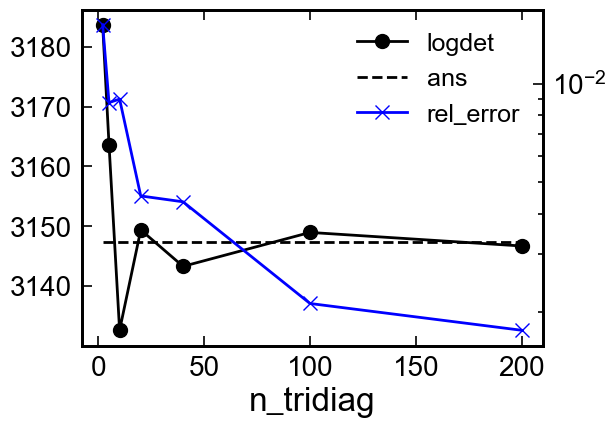

In [29]:
fig, ax = plt.subplots()
ax.plot(n_tridiag_list, logdet_list, marker='o', label='logdet')
ax.hlines(logdet_linalg, n_tridiag_list[0], n_tridiag_list[-1], linestyle='--', label='ans')
ax.set_xlabel('n_tridiag')
ax2 = ax.twinx()
ax2.semilogy(n_tridiag_list, rel_error_list, color='b', marker='x', label='rel_error')

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
# Create a legend for the first line in each axes
ax.legend(lines + lines2, labels + labels2, loc='best')

In [ ]:
rank_list = [0, 2, 5, 10, 20,40,80, 3000]
rank_list = [0, 5, 10, 50, 100, 500]
logdet_list = []
rel_error_list = []
for rank in rank_list:
    logdet, logdet_linalg, rel_err = check_logdet(n_tridiag=10, rank=rank, max_tridiag_iter=50)
    logdet_list.append(logdet)
    rel_error_list.append(rel_err)

In [ ]:
fig, ax = plt.subplots()
ax.plot(rank_list, logdet_list, marker='o', label='logdet')
ax.hlines(logdet_linalg, rank_list[0], rank_list[-1], linestyle='--', label='ans')
ax.set_xlabel('rank')
ax2 = ax.twinx()
ax2.semilogy(rank_list, rel_error_list, color='b', marker='x', label='rel_error')

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
# Create a legend for the first line in each axes
ax.legend(lines + lines2, labels + labels2, loc='best')

In [236]:
jnp.linalg.cond(K)

DeviceArray(2.98729651, dtype=float64)

### N=7000

In [159]:
N = 7000
rank=15
noise = 1e-06
n_tridiag = 10
K = generate_K(N)
precondition, precond_lt, precond_logdet_cache = precond.setup_preconditioner(K, rank=rank, noise=noise)
y = jax.random.normal(key=jax.random.PRNGKey(0), shape=(N,1))
if precondition:
    zs = jax.random.multivariate_normal(
            jax.random.PRNGKey(0),
            jnp.zeros(len(y)),
            precond_lt,
            shape=(n_tridiag,),
    ).T
else:
    zs = jax.random.normal(jax.random.PRNGKey(0), (N, n_tridiag))
K_torch = torch.from_numpy(np.array(K))
rhs = jnp.concatenate([zs, y], axis=1)
rhs_torch = torch.from_numpy(np.array(rhs))

In [160]:
Kinvy_linalg = jnp.linalg.solve(K, rhs)

In [162]:
precondition, precond_lt, precond_logdet_cache = precond.setup_preconditioner(K, rank=rank, noise=noise)
Kinvy, j, t_mat= cg.mpcg_bbmm(K, rhs, precondition=precondition, print_process=True, tolerance=0.01, n_tridiag=n_tridiag)
print(rel_error(Kinvy_linalg, Kinvy))

j=0 r1norm: 0.9391067610671915
j=1 r1norm: 0.917918143723665
j=2 r1norm: 0.9130531920376856
j=3 r1norm: 0.9124254315125387
j=4 r1norm: 0.9123661416989475
j=5 r1norm: 0.9122615106381415
j=6 r1norm: 0.9107938321567703
j=7 r1norm: 0.8903422641099534
j=8 r1norm: 0.7020234332253318
j=9 r1norm: 0.28727865663878643
j=10 r1norm: 0.08312585152070112
j=11 r1norm: 0.02475743763235144
j=12 r1norm: 0.009046651164862097
j=13 r1norm: 0.004788316773479587
j=14 r1norm: 0.0028720092347572653
j=15 r1norm: 0.001036345510922713
j=16 r1norm: 0.00028167873500318537
j=17 r1norm: 7.580046858754703e-05
j=18 r1norm: 1.9946898483479506e-05
j=19 r1norm: 5.344976378002605e-06
j=20 r1norm: 1.4376086554975945e-06
converged
0.0001174276183541353


In [163]:
K_linear_op = linear_operator.to_linear_operator(K_torch)
diag_tensor = torch.ones(N, dtype=torch.float64)*noise
diag_linear_op = DiagLinearOperator(diag_tensor)
added_diag = AddedDiagLinearOperator(K_linear_op, diag_linear_op)

In [164]:
preconditioner_torch, _, precond_logdet_torch = added_diag._preconditioner()
Kinvy_torch, t_mat_torch = added_diag._solve(rhs_torch, preconditioner=preconditioner_torch, num_tridiag=n_tridiag)
print(rel_error(Kinvy_linalg, Kinvy_torch.numpy()))
linear_operator.settings.cg_tolerance._set_value(1)

0.00013994710861929468


In [166]:
logdet = calc_logdet.calc_logdet(K.shape, t_mat, precond_logdet_cache)
logdet, precond_logdet_cache

(DeviceArray(7322.34028093, dtype=float64),
 DeviceArray(-96482.98874765, dtype=float64))

In [167]:
added_diag.inv_quad_log_det(inv_quad_rhs=rhs_torch[:, -1:], logdet=True)

(tensor(2554.9792, dtype=torch.float64),
 tensor(7334.4098, dtype=torch.float64))

In [168]:
eval_torch, evec_torch = linear_operator.utils.lanczos.lanczos_tridiag_to_diag(t_mat_torch)
slq = linear_operator.utils.stochastic_lq.StochasticLQ()
(logdet_term,) = slq.to_dense(added_diag.matrix_shape, eval_torch, evec_torch,  [lambda x: x.log()])

In [169]:
logdet_term + precond_logdet_torch

tensor(7322.3428, dtype=torch.float64)

In [170]:
logdet_linalg = calc_logdet_linalg(K)
logdet_linalg

DeviceArray(7343.7469261, dtype=float64)